In [ ]:
# CELL 1: Install & imports + reproducibility helper
!pip install --upgrade transformers datasets peft accelerate -q

import os, time, json, random
import numpy as np
import torch
import torch.nn.functional as F
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, DataCollatorForLanguageModeling
from peft import LoraConfig, get_peft_model
from torch.utils.data import DataLoader
from torch.optim import AdamW
import matplotlib.pyplot as plt
import pandas as pd

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

print("Imports done. PyTorch:", torch.__version__, "CUDA available:", torch.cuda.is_available())
set_seed(42)


Imports done. PyTorch: 2.8.0+cu126 CUDA available: True


In [ ]:
# CELL 2: CONFIG (edit to tune experiment)
MODEL_NAME = "gpt2"       # small model; change only if you know hardware
TRAIN_SIZE_A = 3000       # IMDb train size
TRAIN_SIZE_B = 3000       # Yelp train size
EVAL_SIZE = 1000          # Eval size per domain
MAX_LENGTH = 128
BATCH_SIZE = 8
NUM_EPOCHS_A = 3
NUM_EPOCHS_B = 3
LORA_R = 64               # research-grade high rank
LORA_ALPHA = 32
LORA_DROPOUT = 0.05
LAMBDA_DC = 0.1           # domain correlation loss weight
LAMBDA_ORDER = 1e-4       # ordering regularizer weight
CHECKPOINT_DIR = "./checkpoints_hybrid"
RESULTS_DIR = "./results"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)

print("CONFIG:", {k: locals()[k] for k in ["MODEL_NAME","TRAIN_SIZE_A","TRAIN_SIZE_B","BATCH_SIZE","NUM_EPOCHS_A","NUM_EPOCHS_B","LORA_R"]})


CONFIG: {'MODEL_NAME': 'gpt2', 'TRAIN_SIZE_A': 3000, 'TRAIN_SIZE_B': 3000, 'BATCH_SIZE': 8, 'NUM_EPOCHS_A': 3, 'NUM_EPOCHS_B': 3, 'LORA_R': 64}


In [ ]:
# CELL 3: Load datasets
print("Loading datasets (may take a minute)...")
dataset_imdb = load_dataset("imdb")
dataset_yelp = load_dataset("yelp_polarity")

train_A = dataset_imdb["train"].shuffle(seed=42).select(range(TRAIN_SIZE_A))
eval_A  = dataset_imdb["test"].shuffle(seed=42).select(range(EVAL_SIZE))

train_B = dataset_yelp["train"].shuffle(seed=42).select(range(TRAIN_SIZE_B))
eval_B  = dataset_yelp["test"].shuffle(seed=42).select(range(EVAL_SIZE))

print(f"Domain A (IMDb): {len(train_A)} train, {len(eval_A)} eval")
print(f"Domain B (Yelp): {len(train_B)} train, {len(eval_B)} eval")


Loading datasets (may take a minute)...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/256M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/17.7M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/560000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/38000 [00:00<?, ? examples/s]

Domain A (IMDb): 3000 train, 1000 eval
Domain B (Yelp): 3000 train, 1000 eval


In [ ]:
# CELL 4 (UPDATED) — Tokenizer & model init helper (DyLoRA-safe)
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import LoraConfig, get_peft_model

# --- Tokenizer ---
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer.pad_token = tokenizer.eos_token  # ensures padding defined

# --- LoRA config template (reusable across rebuilds) ---
lora_cfg = LoraConfig(
    r=LORA_R,
    lora_alpha=LORA_ALPHA,
    target_modules=["c_attn"],  # GPT-2 combined QKV name
    lora_dropout=LORA_DROPOUT,
    bias="none",
    task_type="CAUSAL_LM"
)

# --- Base (unwrapped) model initializer ---
def make_base_model_init():
    def init_base():
        return AutoModelForCausalLM.from_pretrained(MODEL_NAME)
    return init_base

base_model_init_fn = make_base_model_init()

# --- PEFT-wrapped model creator (for initial training start) ---
def make_peft_model_from_base_init(base_init_fn, lora_config):
    """
    Given a base-model init function and a LoRA config, return a PEFT-wrapped model.
    This is a small helper used by run_experiment and multi-seed wrappers.
    """
    base = base_init_fn()
    peft_model = get_peft_model(base, lora_config)
    return peft_model

# Convenience alias: model_init_fn should return a PEFT model (keeps legacy names working)
def model_init_fn():
    return make_peft_model_from_base_init(base_model_init_fn, lora_cfg)

print("Tokenizer ready. Base + LoRA model builders initialized.")
print("Tokenizer vocab size:", tokenizer.vocab_size)


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Tokenizer ready. Base + LoRA model builders initialized.
Tokenizer vocab size: 50257


In [ ]:
# CELL 5: Tokenize data and create DataLoaders
def tokenize_batch(batch):
    enc = tokenizer(batch["text"], padding="max_length", truncation=True, max_length=MAX_LENGTH)
    enc["labels"] = enc["input_ids"].copy()
    return enc

train_A_enc = train_A.map(tokenize_batch, batched=True, remove_columns=["text"])
eval_A_enc  = eval_A.map(tokenize_batch, batched=True, remove_columns=["text"])
train_B_enc = train_B.map(tokenize_batch, batched=True, remove_columns=["text"])
eval_B_enc  = eval_B.map(tokenize_batch, batched=True, remove_columns=["text"])

data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

train_loader_A = DataLoader(train_A_enc, batch_size=BATCH_SIZE, shuffle=True, collate_fn=data_collator)
eval_loader_A  = DataLoader(eval_A_enc, batch_size=BATCH_SIZE, shuffle=False, collate_fn=data_collator)
train_loader_B = DataLoader(train_B_enc, batch_size=BATCH_SIZE, shuffle=True, collate_fn=data_collator)
eval_loader_B  = DataLoader(eval_B_enc, batch_size=BATCH_SIZE, shuffle=False, collate_fn=data_collator)

print("DataLoaders ready. Batches per epoch (A):", len(train_loader_A), " (B):", len(train_loader_B))


Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

DataLoaders ready. Batches per epoch (A): 375  (B): 375


In [ ]:
# CELL 6: Utilities
def flatten_lora_params(model):
    """Concatenate all LoRA A and B weights into a single 1D tensor on CPU."""
    lora_tensors = []
    for _, module in model.named_modules():
        if hasattr(module, "lora_A") and hasattr(module, "lora_B"):
            # handle ModuleDict('default') pattern
            A = getattr(module.lora_A, "default", module.lora_A)
            B = getattr(module.lora_B, "default", module.lora_B)
            if hasattr(A, "weight"):
                lora_tensors.append(A.weight.detach().view(-1).cpu())
            if hasattr(B, "weight"):
                lora_tensors.append(B.weight.detach().view(-1).cpu())
    if not lora_tensors:
        return torch.tensor([], dtype=torch.float32)
    return torch.cat(lora_tensors)

def domain_correlation_loss_normalized(prev_flat, cur_flat, lambda_corr=LAMBDA_DC):
    """Normalized cosine similarity over flattened adapter params (robust to scale)."""
    if prev_flat is None or cur_flat is None:
        return torch.tensor(0.0, device=(cur_flat.device if cur_flat is not None else "cpu"))
    if prev_flat.numel() == 0 or cur_flat.numel() == 0:
        return torch.tensor(0.0, device=cur_flat.device)
    l = min(prev_flat.numel(), cur_flat.numel())
    prev = prev_flat[:l].float().clone()
    cur  = cur_flat[:l].float().clone()
    prev = prev / (prev.norm() + 1e-9)
    cur  = cur / (cur.norm() + 1e-9)
    sim = F.cosine_similarity(prev.unsqueeze(0), cur.unsqueeze(0), dim=1).mean()
    return lambda_corr * (1.0 - sim)

def ordering_regularizer(model, lambda_order=LAMBDA_ORDER):
    """Encourage higher magnitude for earlier components (soft ordering)."""
    loss = torch.tensor(0.0, device=next(model.parameters()).device)
    for _, module in model.named_modules():
        if hasattr(module, "lora_A") and hasattr(module, "lora_B"):
            A = getattr(module.lora_A, "default", module.lora_A)
            B = getattr(module.lora_B, "default", module.lora_B)
            if not (hasattr(A,"weight") and hasattr(B,"weight")):
                continue
            # A (r, d_in), B (d_out, r)
            r = A.weight.shape[0]
            mags = torch.sqrt(A.weight.pow(2).sum(dim=1) + 1e-12) * torch.sqrt(B.weight.pow(2).sum(dim=0) + 1e-12)
            idx = torch.arange(0, r, device=mags.device).float()
            weights = (idx / float(max(1, r-1)))
            loss = loss + lambda_order * torch.dot(weights, mags)
    return loss

def set_lora_rank_via_truncation(model, new_rank):
    """Truncate LoRA A,B to first new_rank components (in-place)."""
    for name, module in model.named_modules():
        if hasattr(module, "lora_A") and hasattr(module, "lora_B"):
            A = getattr(module.lora_A, "default", module.lora_A)
            B = getattr(module.lora_B, "default", module.lora_B)
            with torch.no_grad():
                if hasattr(A, "weight") and hasattr(B, "weight"):
                    r_old = A.weight.shape[0]
                    if new_rank >= r_old:
                        continue
                    A.weight.data = A.weight.data[:new_rank, :].clone()
                    B.weight.data = B.weight.data[:, :new_rank].clone()
    print(f"[Truncation] LoRA rank truncated to {new_rank}")


In [ ]:
# CELL 7: Evaluation helpers
def evaluate_loss_and_token_acc(model, dataloader, device):
    model.eval()
    criterion = torch.nn.CrossEntropyLoss(ignore_index=-100)
    total_loss = 0.0
    total_tokens = 0
    correct = 0
    with torch.no_grad():
        for batch in dataloader:
            inputs = batch["input_ids"].to(device)
            masks = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            outputs = model(input_ids=inputs, attention_mask=masks)
            logits = outputs.logits
            shift_logits = logits[..., :-1, :].contiguous()
            shift_labels = labels[..., 1:].contiguous()
            loss = criterion(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
            total_loss += loss.item() * shift_labels.size(0)
            preds = shift_logits.argmax(dim=-1)
            mask = (shift_labels != -100)
            correct += (preds[mask] == shift_labels[mask]).sum().item()
            total_tokens += mask.sum().item()
    avg_loss = total_loss / len(dataloader.dataset)
    token_acc = correct / total_tokens if total_tokens>0 else 0.0
    return avg_loss, token_acc


In [ ]:
# CELL 8
# --- SAFE DYLoRA UPDATE FIX ---
def safe_dylora_rank_update(model, epoch, dynamic_schedule_B):
    """
    Change LoRA rank *only between epochs*, after gradients are cleared.
    """
    if dynamic_schedule_B and epoch in dynamic_schedule_B:
        new_rank = dynamic_schedule_B[epoch]
        torch.cuda.empty_cache()  # clear leftover allocations
        print(f"[DyLoRA] Epoch {epoch}: safely updating rank to {new_rank}")
        set_lora_rank(model, new_rank)
        print_lora_ranks(model, max_print=3)


In [ ]:
# ✅ UPDATED CELL 9 — Safe rebuild + training loop (DyLoRA-compatible)

import torch, copy, os
from peft import get_peft_model, LoraConfig
from torch.optim import AdamW

def rebuild_model_for_new_rank(old_model, new_r, base_model_init_fn, lora_config_template, device):
    """
    Safely rebuild a LoRA model at a new rank by creating a new PEFT wrapper
    around a fresh GPT-2 base, copying overlapping adapter weights.
    """
    base_new = base_model_init_fn()                     # fresh GPT-2 base
    new_cfg = copy.deepcopy(lora_config_template)
    new_cfg.r = new_r
    new_peft = get_peft_model(base_new, new_cfg).to(device)

    old_state, new_state = old_model.state_dict(), new_peft.state_dict()
    copied = 0
    for k, v_old in old_state.items():
        if k in new_state and isinstance(v_old, torch.Tensor):
            v_new = new_state[k]
            shape = tuple(min(a, b) for a, b in zip(v_old.shape, v_new.shape))
            if all(s > 0 for s in shape):
                slices = tuple(slice(0, s) for s in shape)
                v_new[slices] = v_old[slices].to(v_new.device)
                copied += 1
    new_peft.load_state_dict(new_state, strict=False)
    print(f"[rebuild] Recreated model with r={new_r}. Copied {copied} tensors.")
    return new_peft


def train_one_domain(model, train_loader, eval_loader, device, prev_lora_flat=None,
                     epochs=3, lr=5e-5, lambda_corr=0.1, dynamic_rank_schedule=None,
                     save_checkpoint_path=None, base_model_init_fn=None, lora_config_template=None):
    """
    DyLoRA-safe training loop with optional rank rebuilding.
    """
    model.to(device)
    optimizer = AdamW(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss(ignore_index=-100)
    history = {"epoch": [], "train_loss": [], "eval_loss": [], "eval_acc": []}

    for epoch in range(1, epochs + 1):
        # Handle dynamic rank update
        if dynamic_rank_schedule and epoch in dynamic_rank_schedule:
            new_r = dynamic_rank_schedule[epoch]
            print(f"[Epoch {epoch}] → dynamic rank {new_r}")
            torch.cuda.empty_cache()
            model = rebuild_model_for_new_rank(model, new_r, base_model_init_fn, lora_config_template, device)
            optimizer = AdamW(model.parameters(), lr=lr)

        model.train()
        total_loss = 0.0
        for batch in train_loader:
            inputs = batch["input_ids"].to(device)
            labels = batch["labels"].to(device)
            outputs = model(input_ids=inputs)
            logits = outputs.logits[..., :-1, :].contiguous()
            lbls = labels[..., 1:].contiguous()
            loss_ce = criterion(logits.view(-1, logits.size(-1)), lbls.view(-1))

            # Domain correlation loss
            if prev_lora_flat is not None and prev_lora_flat.numel() > 0:
                cur_flat = flatten_lora_params(model).to(device)
                loss_dc = domain_correlation_loss_normalized(prev_lora_flat.to(device), cur_flat, lambda_corr)
            else:
                loss_dc = torch.tensor(0.0, device=device)

            # Ordering regularizer
            try:
                loss_order = ordering_regularizer(model, LAMBDA_ORDER)
            except Exception:
                loss_order = torch.tensor(0.0, device=device)

            loss = loss_ce + loss_dc + loss_order
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        eval_loss, eval_acc = evaluate_loss_and_token_acc(model, eval_loader, device)
        avg_train_loss = total_loss / len(train_loader)
        print(f"[Epoch {epoch}] train_loss={avg_train_loss:.4f} eval_loss={eval_loss:.4f} eval_acc={eval_acc:.4f}")

        history["epoch"].append(epoch)
        history["train_loss"].append(avg_train_loss)
        history["eval_loss"].append(eval_loss)
        history["eval_acc"].append(eval_acc)

        if save_checkpoint_path:
            os.makedirs(save_checkpoint_path, exist_ok=True)
            torch.save(model.state_dict(), os.path.join(save_checkpoint_path, f"ckpt_epoch{epoch}.pt"))
    final_flat = flatten_lora_params(model).cpu()
    return model, final_flat, history


In [ ]:
# CELL 10
# 🔧 Add this helper for DC-LoRA correlation loss
import torch.nn.functional as F

def domain_correlation_loss(W_prev, W_new, lambda_corr=0.1):
    """
    Compute domain correlation loss to reduce catastrophic forgetting.
    It encourages LoRA parameters of the new task to stay similar to the previous task.
    """
    # Cosine similarity between flattened LoRA weights
    sim = F.cosine_similarity(W_prev.unsqueeze(0), W_new.unsqueeze(0), dim=1).mean()
    loss = lambda_corr * (1 - sim)  # Higher similarity -> lower penalty
    return loss


In [ ]:
# ✅ CELL 11: run_experiment with full history, DC, DyLoRA, and ordering
def run_experiment(run_name, model_init_fn, train_loader_A, eval_loader_A,
                   train_loader_B, eval_loader_B, device, seed=42,
                   use_dc=True, use_dy=True, lambda_dc=0.1,
                   dynamic_schedule_B=None, epochs_A=3, epochs_B=3, lr=5e-5):
    """
    Two-stage domain adaptation (A→B) with LoRA / DyLoRA / DC-LoRA hybrids.
    Tracks per-epoch history for plotting.
    """

    set_seed(seed)
    os.makedirs(os.path.join(RESULTS_DIR, run_name), exist_ok=True)
    print(f"[{run_name}] Stage 1 (Domain A) starting")

    # ===== Stage 1: Domain A pretraining =====
    model = model_init_fn().to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

    hist_A = {"epoch": [], "train_loss": [], "eval_loss": [], "eval_acc": []}

    for epoch in range(1, epochs_A + 1):
        model.train()
        total_loss = 0
        for batch in train_loader_A:
            optimizer.zero_grad()
            inputs = batch["input_ids"].to(device)
            labels = batch["labels"].to(device)
            logits = model(input_ids=inputs).logits[..., :-1, :]
            lbls = labels[..., 1:]
            loss = torch.nn.CrossEntropyLoss(ignore_index=-100)(logits.reshape(-1, logits.size(-1)), lbls.reshape(-1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        # Evaluate Stage 1
        avg_train_loss = total_loss / len(train_loader_A)
        val_loss, val_acc = evaluate_loss_and_token_acc(model, eval_loader_A, device)
        hist_A["epoch"].append(epoch)
        hist_A["train_loss"].append(avg_train_loss)
        hist_A["eval_loss"].append(val_loss)
        hist_A["eval_acc"].append(val_acc)
        print(f"[Epoch {epoch}] train_loss={avg_train_loss:.4f} eval_loss={val_loss:.4f} eval_acc={val_acc:.4f}")

    # Save Stage-1 model and tokenizer
    model.save_pretrained(os.path.join(RESULTS_DIR, run_name, "model_A"))
    tokenizer.save_pretrained(os.path.join(RESULTS_DIR, run_name, "tokenizer"))

    # ===== Stage 2: Domain B fine-tuning =====
    prev_flat = flatten_lora_params(model)
    lam = lambda_dc if use_dc else 0.0
    dsched = dynamic_schedule_B if use_dy else None
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

    print(f"[{run_name}] Stage 2 (Domain B) starting: use_dc={use_dc}, use_dy={use_dy}, λ_dc={lam}")
    hist_B = {"epoch": [], "train_loss": [], "eval_loss": [], "eval_acc": []}

    for epoch in range(1, epochs_B + 1):
        # DyLoRA dynamic rank adaptation
        if use_dy and dsched and epoch in dsched:
            new_r = dsched[epoch]
            print(f"[DyLoRA] Epoch {epoch}: rebuilding → rank {new_r}")
            torch.cuda.empty_cache()
            model = rebuild_model_for_new_rank(model, new_r, base_model_init_fn, lora_cfg, device)
            optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

        model.train()
        total_loss = 0
        for batch in train_loader_B:
            optimizer.zero_grad()
            inputs = batch["input_ids"].to(device)
            labels = batch["labels"].to(device)
            logits = model(input_ids=inputs).logits[..., :-1, :]
            lbls = labels[..., 1:]

            loss = torch.nn.CrossEntropyLoss(ignore_index=-100)(logits.reshape(-1, logits.size(-1)), lbls.reshape(-1))

            # Domain Correlation Loss
            if use_dc:
                cur_flat = flatten_lora_params(model)
                loss += domain_correlation_loss_normalized(prev_flat.to(cur_flat.device), cur_flat, lam)

            # Ordering Regularizer
            loss += ordering_regularizer(model, LAMBDA_ORDER)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        # Evaluate Stage 2
        avg_train_loss = total_loss / len(train_loader_B)
        val_loss, val_acc = evaluate_loss_and_token_acc(model, eval_loader_B, device)
        hist_B["epoch"].append(epoch)
        hist_B["train_loss"].append(avg_train_loss)
        hist_B["eval_loss"].append(val_loss)
        hist_B["eval_acc"].append(val_acc)
        print(f"[Epoch {epoch}] train_loss={avg_train_loss:.4f} eval_loss={val_loss:.4f} eval_acc={val_acc:.4f}")

    # ===== Evaluation summary =====
    evalA_loss, evalA_acc = evaluate_loss_and_token_acc(model, eval_loader_A, device)
    evalB_onA_loss, evalB_onA_acc = evaluate_loss_and_token_acc(model, eval_loader_A, device)
    evalB_loss, evalB_acc = evaluate_loss_and_token_acc(model, eval_loader_B, device)

    results = {
        "run_name": run_name, "seed": seed, "use_dc": use_dc, "use_dy": use_dy,
        "evalA_before_loss": float(evalA_loss), "evalA_before_acc": float(evalA_acc),
        "evalB_onA_loss": float(evalB_onA_loss), "evalB_onA_acc": float(evalB_onA_acc),
        "evalB_onB_loss": float(evalB_loss), "evalB_onB_acc": float(evalB_acc),
        "hist_A": hist_A, "hist_B": hist_B
    }

    with open(os.path.join(RESULTS_DIR, f"{run_name}_results.json"), "w") as f:
        json.dump(results, f, indent=2)

    print(f"[{run_name}] finished. Results saved to {RESULTS_DIR}/{run_name}_results.json")
    return results


In [ ]:
# CELL 12
# --- FIX CELL: helpers for DyLoRA rank changes, printing ranks, and HF timeout ---
import os
import torch

# (A) Increase HF hub request timeout to reduce ReadTimeouts (helps transient network issues)
# This environment var is respected by huggingface_hub in many versions.
os.environ["HF_HUB_REQUEST_TIMEOUT"] = "60"   # seconds

# (B) Robust set_lora_rank that can BOTH truncate and expand LoRA adapters safely.
def set_lora_rank(model, new_r):
    """
    Safely change LoRA adapter rank across modules.
    - Truncates if new_r < old_r
    - Pads with zeros if new_r > old_r
    Must be used BETWEEN epochs (not during backprop).
    """
    changed = 0
    for name, module in model.named_modules():
        if hasattr(module, "lora_A") and hasattr(module, "lora_B"):
            A = getattr(module.lora_A, "default", module.lora_A)
            B = getattr(module.lora_B, "default", module.lora_B)
            if not (hasattr(A, "weight") and hasattr(B, "weight")):
                continue
            with torch.no_grad():
                r_old = A.weight.shape[0]
                d_in = A.weight.shape[1]
                d_out = B.weight.shape[0]
                if new_r == r_old:
                    continue
                if new_r < r_old:
                    A.weight.data = A.weight.data[:new_r, :].clone()
                    B.weight.data = B.weight.data[:, :new_r].clone()
                else:
                    # pad with zeros (safe initialization)
                    padA = torch.zeros((new_r - r_old, d_in), device=A.weight.device, dtype=A.weight.dtype)
                    padB = torch.zeros((d_out, new_r - r_old), device=B.weight.device, dtype=B.weight.dtype)
                    A.weight.data = torch.cat([A.weight.data, padA], dim=0)
                    B.weight.data = torch.cat([B.weight.data, padB], dim=1)
                changed += 1
    print(f"[set_lora_rank] Applied new_r={new_r}. Modules modified: {changed}")

# (C) Utility to print current LoRA rank summary (for logging)
def print_lora_ranks(model, max_print=20):
    ranks = []
    for name, module in model.named_modules():
        if hasattr(module, "lora_A") and hasattr(module, "lora_B"):
            A = getattr(module.lora_A, "default", module.lora_A)
            B = getattr(module.lora_B, "default", module.lora_B)
            if hasattr(A, "weight") and hasattr(B, "weight"):
                r = A.weight.shape[0]
                ranks.append((name, r))
                if len(ranks) >= max_print:
                    break
    print("[LoRA ranks] sample modules (name, rank):")
    for nm, r in ranks:
        print(f"  - {nm}: {r}")
    if not ranks:
        print("  (no LoRA modules found)")

# (D) If you want, create an alias to ensure older code using set_lora_rank_via_truncation still works
def set_lora_rank_via_truncation(model, k):
    # wrapper alias; retains name used earlier
    set_lora_rank(model, k)

print("LoRA helpers installed. HF timeout set to", os.environ.get("HF_HUB_REQUEST_TIMEOUT"))


LoRA helpers installed. HF timeout set to 60


In [ ]:
# CELL 13 (UPDATED) — Run baselines and hybrid (single-seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# schedules for DyLoRA (example)
dynamic_schedule_B_example = {1: LORA_R, 2: max(8, LORA_R//2), 3: max(4, LORA_R//4)}

# LoRA-only baseline (no DC, no Dy)
res_lora_only = run_experiment(
    "lora_only",
    lambda: make_peft_model_from_base_init(base_model_init_fn, lora_cfg),
    train_loader_A, eval_loader_A, train_loader_B, eval_loader_B,
    device, seed=42, use_dc=False, use_dy=False, dynamic_schedule_B=None
)

# DyLoRA-only (Dy schedule but no DC)
res_dy_only = run_experiment(
    "dy_only",
    lambda: make_peft_model_from_base_init(base_model_init_fn, lora_cfg),
    train_loader_A, eval_loader_A, train_loader_B, eval_loader_B,
    device, seed=42, use_dc=False, use_dy=True, dynamic_schedule_B=dynamic_schedule_B_example
)

# DC-LoRA-only (DC loss but no Dy)
res_dc_only = run_experiment(
    "dc_only",
    lambda: make_peft_model_from_base_init(base_model_init_fn, lora_cfg),
    train_loader_A, eval_loader_A, train_loader_B, eval_loader_B,
    device, seed=42, use_dc=True, use_dy=False, lambda_dc=LAMBDA_DC
)

# Hybrid Dy + DC
res_hybrid = run_experiment(
    "hybrid",
    lambda: make_peft_model_from_base_init(base_model_init_fn, lora_cfg),
    train_loader_A, eval_loader_A, train_loader_B, eval_loader_B,
    device, seed=42, use_dc=True, use_dy=True, lambda_dc=LAMBDA_DC, dynamic_schedule_B=dynamic_schedule_B_example
)


Device: cuda
[lora_only] Stage 1 (Domain A) starting
[Epoch 1] train_loss=3.9083 eval_loss=3.6991 eval_acc=0.3319
[Epoch 2] train_loss=3.8155 eval_loss=3.6767 eval_acc=0.3339
[Epoch 3] train_loss=3.7882 eval_loss=3.6664 eval_acc=0.3343
[lora_only] Stage 2 (Domain B) starting: use_dc=False, use_dy=False, λ_dc=0.0
[Epoch 1] train_loss=3.8072 eval_loss=3.6004 eval_acc=0.3279
[Epoch 2] train_loss=3.7273 eval_loss=3.5755 eval_acc=0.3302
[Epoch 3] train_loss=3.6972 eval_loss=3.5639 eval_acc=0.3322
[lora_only] finished. Results saved to ./results/lora_only_results.json
[dy_only] Stage 1 (Domain A) starting
[Epoch 1] train_loss=3.9083 eval_loss=3.6991 eval_acc=0.3319
[Epoch 2] train_loss=3.8155 eval_loss=3.6767 eval_acc=0.3339
[Epoch 3] train_loss=3.7882 eval_loss=3.6664 eval_acc=0.3343
[dy_only] Stage 2 (Domain B) starting: use_dc=False, use_dy=True, λ_dc=0.0
[DyLoRA] Epoch 1: rebuilding → rank 64
[rebuild] Recreated model with r=64. Copied 173 tensors.
[Epoch 1] train_loss=3.8102 eval_loss=3

In [ ]:
# CELL 14A — Multi-seed (hybrid only)
def run_multiple_seeds_for_hybrid(name, use_dc, use_dy, seeds=[42, 101, 7]):
    rows = []
    for s in seeds:
        r = run_experiment(
            f"{name}_s{s}",
            lambda: make_peft_model_from_base_init(base_model_init_fn, lora_cfg),
            train_loader_A, eval_loader_A, train_loader_B, eval_loader_B,
            device, seed=s, use_dc=use_dc, use_dy=use_dy,
            lambda_dc=LAMBDA_DC, dynamic_schedule_B=dynamic_schedule_B_example
        )
        rows.append({
            "run": r["run_name"], "seed": r["seed"],
            "use_dc": r["use_dc"], "use_dy": r["use_dy"],
            "evalA_before_loss": r["evalA_before_loss"], "evalB_onA_loss": r["evalB_onA_loss"],
            "evalB_onB_loss": r["evalB_onB_loss"], "evalA_before_acc": r["evalA_before_acc"], "evalB_onA_acc": r["evalB_onA_acc"]
        })
    df = pd.DataFrame(rows)
    csv_path = os.path.join(RESULTS_DIR, f"{name}_seeds_summary.csv")
    df.to_csv(csv_path, index=False)
    print("Saved seed summary:", csv_path)
    return df

# Run hybrid multi-seed (expensive)
df_hybrid = run_multiple_seeds_for_hybrid("hybrid_multi", use_dc=True, use_dy=True, seeds=[42,43,44])


[hybrid_multi_s42] Stage 1 (Domain A) starting
[Epoch 1] train_loss=3.9083 eval_loss=3.6991 eval_acc=0.3319
[Epoch 2] train_loss=3.8155 eval_loss=3.6767 eval_acc=0.3339
[Epoch 3] train_loss=3.7882 eval_loss=3.6664 eval_acc=0.3343
[hybrid_multi_s42] Stage 2 (Domain B) starting: use_dc=True, use_dy=True, λ_dc=0.1
[DyLoRA] Epoch 1: rebuilding → rank 64
[rebuild] Recreated model with r=64. Copied 173 tensors.
[Epoch 1] train_loss=3.8113 eval_loss=3.6002 eval_acc=0.3279
[DyLoRA] Epoch 2: rebuilding → rank 32
[rebuild] Recreated model with r=32. Copied 173 tensors.
[Epoch 2] train_loss=3.8116 eval_loss=3.5761 eval_acc=0.3306
[DyLoRA] Epoch 3: rebuilding → rank 16
[rebuild] Recreated model with r=16. Copied 173 tensors.
[Epoch 3] train_loss=3.7894 eval_loss=3.5652 eval_acc=0.3317
[hybrid_multi_s42] finished. Results saved to ./results/hybrid_multi_s42_results.json
[hybrid_multi_s43] Stage 1 (Domain A) starting
[Epoch 1] train_loss=3.9094 eval_loss=3.6995 eval_acc=0.3319
[Epoch 2] train_loss=3

In [ ]:
# CELL 14B — Multi-seed (LoRA-only baseline)
def run_multiple_seeds_for_lora(name, use_dc, use_dy, seeds=[42, 101, 7]):
    rows = []
    for s in seeds:
        r = run_experiment(
            f"{name}_s{s}",
            lambda: make_peft_model_from_base_init(base_model_init_fn, lora_cfg),
            train_loader_A, eval_loader_A, train_loader_B, eval_loader_B,
            device, seed=s, use_dc=use_dc, use_dy=use_dy,
            lambda_dc=LAMBDA_DC, dynamic_schedule_B=None
        )
        rows.append({
            "run": r["run_name"],
            "seed": r["seed"],
            "use_dc": r["use_dc"],
            "use_dy": r["use_dy"],
            "evalA_before_loss": r["evalA_before_loss"],
            "evalB_onA_loss": r["evalB_onA_loss"],
            "evalB_onB_loss": r["evalB_onB_loss"],
            "evalA_before_acc": r["evalA_before_acc"],
            "evalB_onA_acc": r["evalB_onA_acc"]
        })
    df = pd.DataFrame(rows)
    csv_path = os.path.join(RESULTS_DIR, f"{name}_seeds_summary.csv")
    df.to_csv(csv_path, index=False)
    print("Saved seed summary:", csv_path)
    return df


# 🔹 Run LoRA-only multi-seed (you can comment this out to run later)
df_lora = run_multiple_seeds_for_lora("lora_multi", use_dc=False, use_dy=False, seeds=[42, 43, 44])


[lora_multi_s42] Stage 1 (Domain A) starting
[Epoch 1] train_loss=3.9083 eval_loss=3.6991 eval_acc=0.3319
[Epoch 2] train_loss=3.8155 eval_loss=3.6767 eval_acc=0.3339
[Epoch 3] train_loss=3.7882 eval_loss=3.6664 eval_acc=0.3343
[lora_multi_s42] Stage 2 (Domain B) starting: use_dc=False, use_dy=False, λ_dc=0.0
[Epoch 1] train_loss=3.8072 eval_loss=3.6004 eval_acc=0.3279
[Epoch 2] train_loss=3.7273 eval_loss=3.5755 eval_acc=0.3302
[Epoch 3] train_loss=3.6972 eval_loss=3.5639 eval_acc=0.3322
[lora_multi_s42] finished. Results saved to ./results/lora_multi_s42_results.json
[lora_multi_s43] Stage 1 (Domain A) starting
[Epoch 1] train_loss=3.9094 eval_loss=3.6995 eval_acc=0.3319
[Epoch 2] train_loss=3.8131 eval_loss=3.6762 eval_acc=0.3338
[Epoch 3] train_loss=3.7903 eval_loss=3.6658 eval_acc=0.3347
[lora_multi_s43] Stage 2 (Domain B) starting: use_dc=False, use_dy=False, λ_dc=0.0
[Epoch 1] train_loss=3.8089 eval_loss=3.5997 eval_acc=0.3271
[Epoch 2] train_loss=3.7224 eval_loss=3.5751 eval_ac

In [ ]:
# ✅ CELL 15: Forgetting & Retention (finalized)
def forgetting_and_retention_from_json(res):
    delta_loss = res["evalB_onA_loss"] - res["evalA_before_loss"]
    retention = res["evalB_onA_acc"] / (res["evalA_before_acc"] + 1e-12)
    return {"delta_loss": float(delta_loss), "retention": float(retention)}

# Quick print for single-seed runs (from Cell 13)
try:
    print("LoRA-only forgetting:", forgetting_and_retention_from_json(res_lora_only))
    print("Dy-only forgetting:", forgetting_and_retention_from_json(res_dy_only))
    print("DC-only forgetting:", forgetting_and_retention_from_json(res_dc_only))
    print("Hybrid forgetting:", forgetting_and_retention_from_json(res_hybrid))
except NameError:
    print("⚠️ Single-seed results not found. Make sure Cell 13 has been executed earlier.")


LoRA-only forgetting: {'delta_loss': 0.0, 'retention': 0.9999999999968903}
Dy-only forgetting: {'delta_loss': 0.0, 'retention': 0.9999999999968964}
DC-only forgetting: {'delta_loss': 0.0, 'retention': 0.9999999999968903}
Hybrid forgetting: {'delta_loss': 0.0, 'retention': 0.9999999999968964}


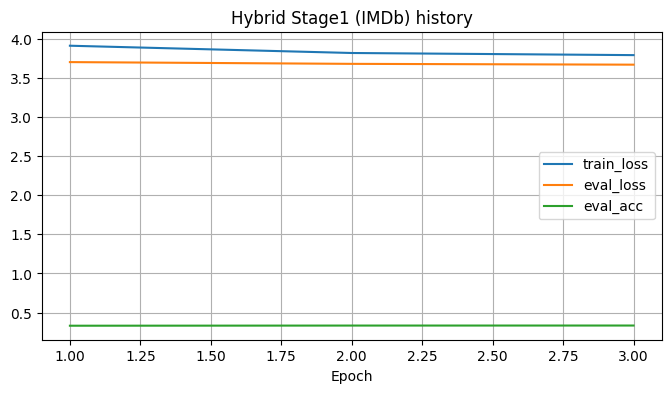

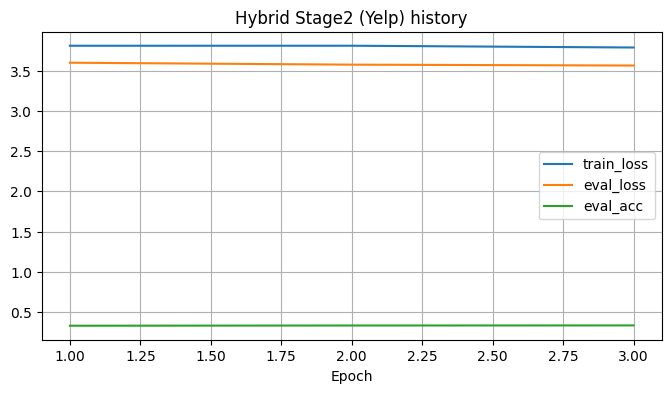

Combined summary saved: ./results/combined_seeds_summary.csv


In [ ]:
# CELL 16: plotting utilities & final summary table creation
def plot_history(hist, title):
    epochs = hist["epoch"]
    plt.figure(figsize=(8,4))
    plt.plot(epochs, hist["train_loss"], label="train_loss")
    plt.plot(epochs, hist["eval_loss"], label="eval_loss")
    plt.plot(epochs, hist["eval_acc"], label="eval_acc")
    plt.title(title)
    plt.xlabel("Epoch")
    plt.legend()
    plt.grid(True)
    plt.show()

# If you ran and have hist_A/hist_B from res_hybrid etc:
try:
    plot_history(res_hybrid["hist_A"], "Hybrid Stage1 (IMDb) history")
    plot_history(res_hybrid["hist_B"], "Hybrid Stage2 (Yelp) history")
except Exception as e:
    print("Plot skipped, history not available:", e)

# create a combined summary CSV if you have multi-seed CSVs
# Example: combine produced CSVs in RESULTS_DIR
csvs = [f for f in os.listdir(RESULTS_DIR) if f.endswith("_seeds_summary.csv")]
if csvs:
    combined = pd.concat([pd.read_csv(os.path.join(RESULTS_DIR, f)) for f in csvs], ignore_index=True)
    combined.to_csv(os.path.join(RESULTS_DIR, "combined_seeds_summary.csv"), index=False)
    print("Combined summary saved:", os.path.join(RESULTS_DIR, "combined_seeds_summary.csv"))
else:
    print("No seed summary CSVs detected yet in", RESULTS_DIR)
